<a href="https://colab.research.google.com/github/piebro/NaoDevils-Segmentation/blob/master/keras_segmentation_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# set up enviroment

In [0]:
# @title mount google drive
from google.colab import drive
drive.mount('/content/drive')

DATASET_DIR = "dataset"
LOG_DIR = "drive/My Drive/pg/logs/seg_custom"
KAGGLE_JSON_PATH_IN_DRIVE = "drive/My Drive/pg/kaggle.json"


import os
if os.path.isfile(KAGGLE_JSON_PATH_IN_DRIVE):
  KAGGLE_JSON_PATH = KAGGLE_JSON_PATH_IN_DRIVE
else:
  from google.colab import files
  uploaded = files.upload()
  KAGGLE_JSON_PATH = "kaggle.json"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#@title install robocup-dataset-loader lib
!git clone -q https://github.com/piebro/NaoDevils-Segmentation.git
!pip install -q kaggle

import sys
sys.path.append("NaoDevils-Segmentation")

%tensorflow_version 2.x 
import dataset_loader
import keras_segmentation

TensorFlow 2.x selected.


In [0]:
#@title Download Kaggle Dataset
dataset_loader.get_dataset(DATASET_DIR, KAGGLE_JSON_PATH)
data_train = dataset_loader.get_data_list(DATASET_DIR, "training")
data_val = dataset_loader.get_data_list(DATASET_DIR, "validation")
num_train_samples = len(data_train)
num_of_val_samples = len(data_val)
#print(data_train[0]["img_path"])
#print(data_train[0]["annotation"])
#print(data_train[0]["meta_info"])
print("There are {} training sameples and {} validation samples".format(num_train_samples, num_of_val_samples))

There are 876 training sameples and 219 validation samples


# Train segmentation example

In [0]:
#@title imports
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

import imgaug as ia
from imgaug import augmenters as iaa

In [0]:
#@title create custom draw mask function
def draw_annotation_mask_no_robots_and_balls(annotations):
  mask = keras_segmentation.get_mask(annotations)
  mask[mask==2] = 0 #2=ball
  mask[mask==3] = 0 #3=robot
  mask[mask>=4] -= 2
  return mask

In [0]:
#@title Keras Model
def get_model_1():
  
  input_height = 480
  input_width = 640
  output_height = 480
  output_width = 640
  get_meta_info = False
  
  n_classes = 6 + 1
  get_mask_function = keras_segmentation.get_mask

  
  inputs = Input((input_height,input_width,3))

  conv1 = Conv2D(filters = 32, kernel_size=1, activation='relu', padding='same')(inputs)
  conv1 = BatchNormalization()(conv1)
  conv1 = Conv2D(filters = 32, kernel_size=3, activation='relu', padding='same')(conv1)
  conv1 = BatchNormalization()(conv1)

  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = SeparableConv2D(48, 3, padding='same', activation='relu', use_bias=False)(pool1)
  conv2 = BatchNormalization()(conv2)

  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = SeparableConv2D(64, 3, padding='same', activation='relu', use_bias=False)(pool2)
  conv3 = BatchNormalization()(conv3)

  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = SeparableConv2D(64, 3, padding='same', activation='relu', use_bias=False)(pool3)
  conv4 = BatchNormalization()(conv4)

  up1 = UpSampling2D(size=(2,2), interpolation='nearest')(conv4)
  concat1 = Concatenate()([up1, conv3])
  conv5 = SeparableConv2D(48, 3, padding='same', activation='relu', use_bias=False)(concat1)
  conv5 = BatchNormalization()(conv5)

  up2 = UpSampling2D(size=(2,2), interpolation='nearest')(conv5)
  concat2 = Concatenate()([up2, conv2])
  conv6 = SeparableConv2D(32, 3, padding='same', activation='relu', use_bias=False)(concat2)
  conv6 = BatchNormalization()(conv6)

  up3 = UpSampling2D(size=(2,2), interpolation='nearest')(conv6)
  concat3 = Concatenate()([up3, conv1])
  conv7 = SeparableConv2D(32, 3, padding='same', activation='relu', use_bias=False)(concat3)
  onv7 = BatchNormalization()(conv7)

  outputs = Conv2D(n_classes, (1,1))(conv7)
  outputs = Activation('softmax')(outputs)

  model = Model(inputs=inputs, outputs=outputs)

  model.n_classes = n_classes
  model.input_height = input_height
  model.input_width = input_width
  model.output_height = output_height
  model.output_width = output_width
  model.get_meta_info = get_meta_info
  model.get_mask_function = get_mask_function
  return model

current_model = get_model_1()
#keras_model.summary()
#print('\nParameter Count:', keras_model.count_params())

In [0]:
#@title define augmentation
aug = iaa.Sequential([
  # apply the following augmenters to most images
  iaa.Fliplr(0.5),  # horizontally flip 50% of all images
  # crop images by -5% to 10% of their height/width
  iaa.Sometimes(0.2, iaa.CropAndPad(
    percent=(-0.1, 0.1),
  )),
  iaa.Sometimes(0.2, iaa.Affine(
    # scale images to 80-120% of their size, individually per axis
    scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
    # translate by -20 to +20 percent (per axis)
    translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
    rotate=(-45, 45),  # rotate by -45 to +45 degrees
    shear=(-16, 16),  # shear by -16 to +16 degrees
    # use nearest neighbour or bilinear interpolation (fast)
    order=[0, 1]
  ))
  ],
  random_order=True)

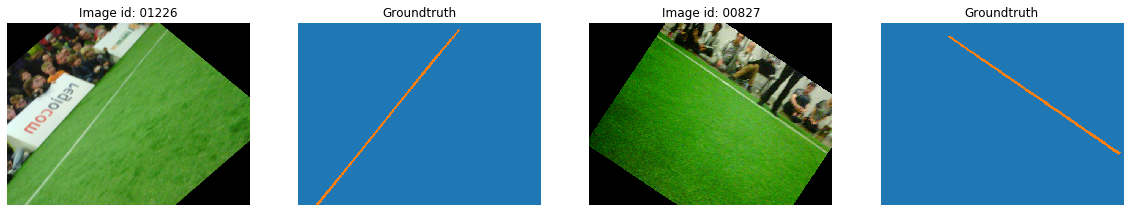

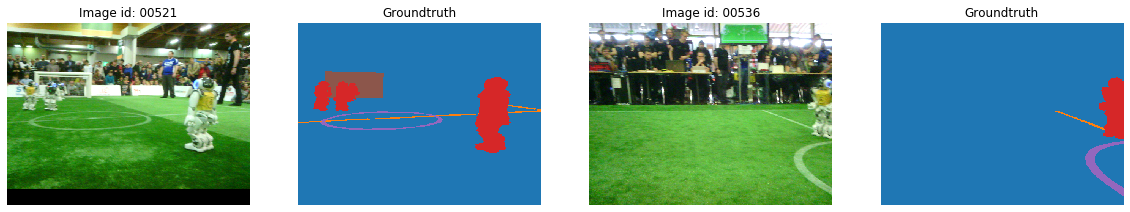

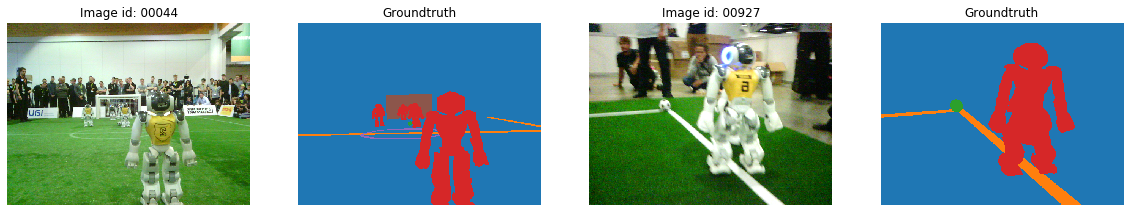

In [0]:
#@title show image and mask with augmentation
keras_segmentation.show_images(
    data_val, keras_segmentation.draw_annotation_segmentation, 6, augmentation=aug)

In [0]:
keras_segmentation.train(current_model,
      data_train,
      data_val,
      LOG_DIR,
      train_str="test",
      epochs=4,
      batch_size=4,
      optimizer_name='adadelta',
      augmentation=aug,
      metrics=['accuracy'],
      loss='categorical_crossentropy'
      )

Model dir is: drive/My Drive/pg/logs/seg_custom/test
Instructions for updating:
Please use Model.fit, which supports generators.
Train for 219 steps, validate for 43 steps
Epoch 1/4
219/219 [==============================] - 125s 573ms/step - loss: 2.0131 - accuracy: 0.0613 - val_loss: 1.9769 - val_accuracy: 0.0516
Epoch 2/4
219/219 [==============================] - 120s 546ms/step - loss: 2.0003 - accuracy: 0.0698 - val_loss: 1.9793 - val_accuracy: 0.0741
Epoch 3/4
219/219 [==============================] - 117s 533ms/step - loss: 1.9868 - accuracy: 0.0832 - val_loss: 1.9716 - val_accuracy: 0.1044
Epoch 4/4
219/219 [==============================] - 118s 539ms/step - loss: 1.9739 - accuracy: 0.1003 - val_loss: 1.9639 - val_accuracy: 0.1204


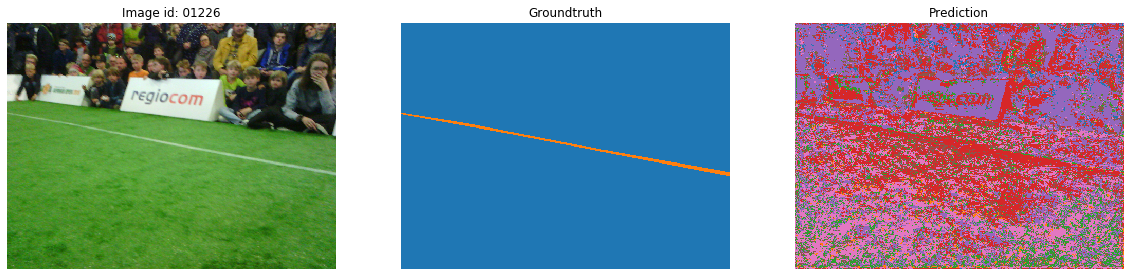

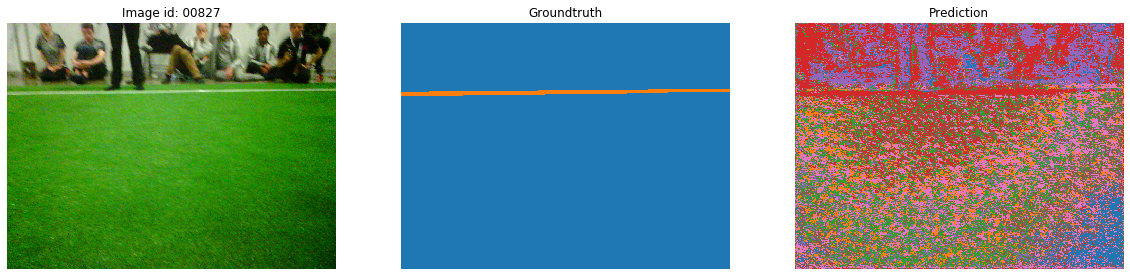

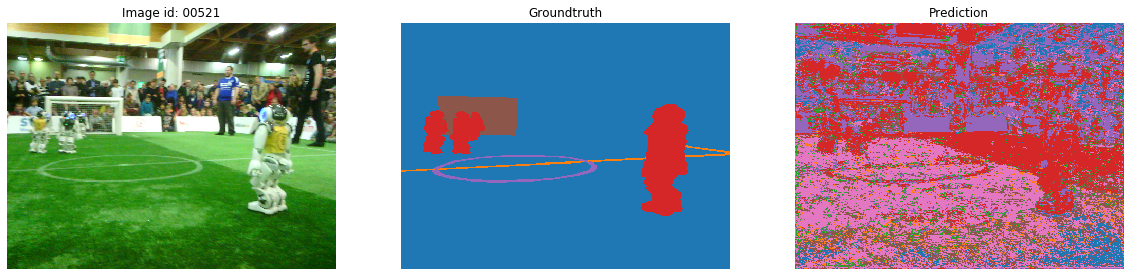

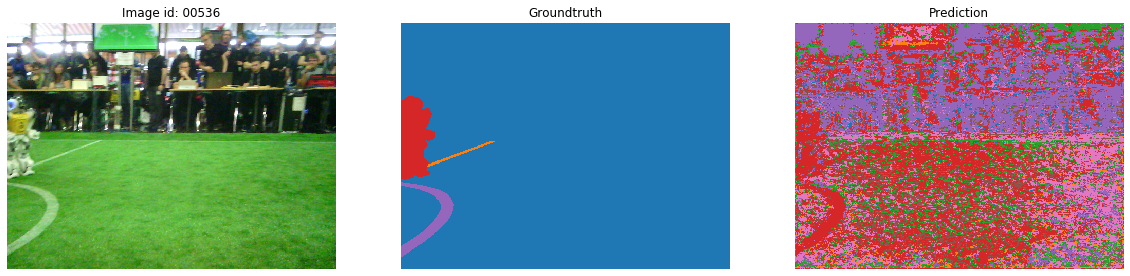

In [0]:
keras_segmentation.show_prediction(current_model, data_val, 4)

In [0]:
%load_ext tensorboard
%tensorboard --logdir "$LOG_DIR"

<IPython.core.display.Javascript object>

#Misc

```javascript
// to keep the connection longer then 30 min in google colab past this in the browser console
function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-toolbar-button#connect").click() 
}
setInterval(ClickConnect,60000)
```

In [0]:
#@title get flops

import tensorflow as tf
import keras.backend as K

g = tf.Graph()
run_meta = tf.RunMetadata()

with g.as_default():
    A = tf.Variable(tf.random_normal([25,16]))
    B = tf.Variable(tf.random_normal([16,9]))
    C = tf.matmul(A,B)
    opts = tf.profiler.ProfileOptionBuilder.float_operation()    
    flops = tf.profiler.profile(g, run_meta=run_meta, cmd='op', options=opts)
    #print(flops.children[0])
    if flops is not None:
        print('TF stats gives',flops.total_float_ops)


#keras_model.summary()
with pipes() as (out, err):
  tf.keras.backend.clear_session()
  get_flops("model.h5")
  print(out.read())

#!pip install wurlitzer

#from wurlitzer import pipes
tf.keras.backend.clear_session()
with pipes() as (out, err):
  get_flops("model.h5")
print (out.read())

def get_flops(model_h5_path):
    session = tf.compat.v1.Session()
    graph = tf.compat.v1.get_default_graph()
        

    with graph.as_default():
        with session.as_default():
            model = tf.keras.models.load_model(model_h5_path)

            #model.compile(loss="categorical_crossentropy",
            #  optimizer="adadelta",
            #  metrics=['accuracy'],)

            run_meta = tf.compat.v1.RunMetadata()
            opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
            #if not debug:
            opts['output'] = "stdout"
        
            # We use the Keras session graph in the call to the profiler.
            flops = tf.compat.v1.profiler.profile(graph=graph,
                                                  run_meta=run_meta, cmd='op', options=opts)
        
            return flops.total_float_ops


#print(tf.__version__)
#tf.keras.backend.clear_session()
#get_flops("model.h5")
#print(get_flops("model.h5"))

#i_s = (1, input_height,input_width,3)
#inputs = Input(batch_input_shape=i_s) #shape=input_shape)